## Exploring different noise schedule

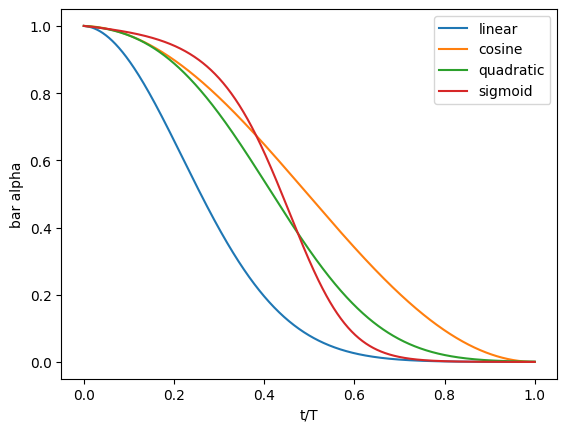

In [1]:
import torch
import matplotlib.pyplot as plt

T = 1000

t_T = torch.arange(T+1) / T

# linear
beta_start = 1e-4
beta_end = 0.02
sig_betas = torch.linspace(beta_start, beta_end, T)
alphas = 1.0 - sig_betas
bar_alphas = torch.cumprod(alphas, dim=0)
bar_alphas = torch.cat([torch.tensor([1.0]), bar_alphas])
plt.plot(t_T, bar_alphas, label="linear")
plt.xlabel("t/T")
plt.ylabel("bar alpha")

# cosine
s = 0.008
t = torch.arange(0, T + 1, dtype=torch.float32)
f_t = torch.cos(((t / T) + s) / (1 + s) * torch.pi / 2) ** 2
bar_alphas = f_t / f_t[0]
plt.plot(t_T, bar_alphas, label="cosine")

# quadratic
sig_betas = torch.linspace(beta_start**0.5, beta_end**0.5, T) ** 2
alphas = 1.0 - sig_betas
bar_alphas = torch.cumprod(alphas, dim=0)
bar_alphas = torch.cat([torch.tensor([1.0]), bar_alphas])
plt.plot(t_T, bar_alphas, label="quadratic")

# sigmoid
sig_betas = torch.linspace(-6, 6, T)
sig_betas = torch.sigmoid(sig_betas) * (beta_end - beta_start) + beta_start
alphas = 1.0 - sig_betas
bar_alphas = torch.cumprod(alphas, dim=0)
bar_alphas = torch.cat([torch.tensor([1.0]), bar_alphas])
plt.plot(t_T, bar_alphas, label="sigmoid")

plt.legend();

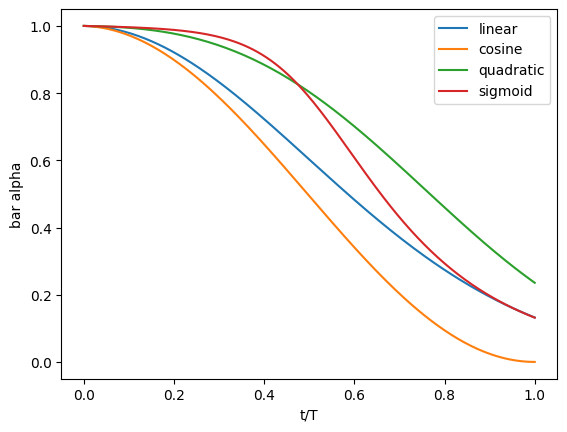

In [2]:
import torch
import matplotlib.pyplot as plt

T = 200

t_T = torch.arange(T+1) / T

# linear
beta_start = 1e-4
beta_end = 0.02
sig_betas = torch.linspace(beta_start, beta_end, T)
alphas = 1.0 - sig_betas
bar_alphas = torch.cumprod(alphas, dim=0)
bar_alphas = torch.cat([torch.tensor([1.0]), bar_alphas])
plt.plot(t_T, bar_alphas, label="linear")
plt.xlabel("t/T")
plt.ylabel("bar alpha")

# cosine
s = 0.008
t = torch.arange(0, T + 1, dtype=torch.float32)
f_t = torch.cos(((t / T) + s) / (1 + s) * torch.pi / 2) ** 2
bar_alphas = f_t / f_t[0]
plt.plot(t_T, bar_alphas, label="cosine")

# quadratic
sig_betas = torch.linspace(beta_start**0.5, beta_end**0.5, T) ** 2
alphas = 1.0 - sig_betas
bar_alphas = torch.cumprod(alphas, dim=0)
bar_alphas = torch.cat([torch.tensor([1.0]), bar_alphas])
plt.plot(t_T, bar_alphas, label="quadratic")

# sigmoid
sig_betas = torch.linspace(-6, 6, T)
sig_betas = torch.sigmoid(sig_betas) * (beta_end - beta_start) + beta_start
alphas = 1.0 - sig_betas
bar_alphas = torch.cumprod(alphas, dim=0)
bar_alphas = torch.cat([torch.tensor([1.0]), bar_alphas])
plt.plot(t_T, bar_alphas, label="sigmoid")

plt.legend();

cosine schedule seems lot more stable towards changes in timesteps

## Log SNR Cosine Inspired Schedule used in Classifier Free Guidance

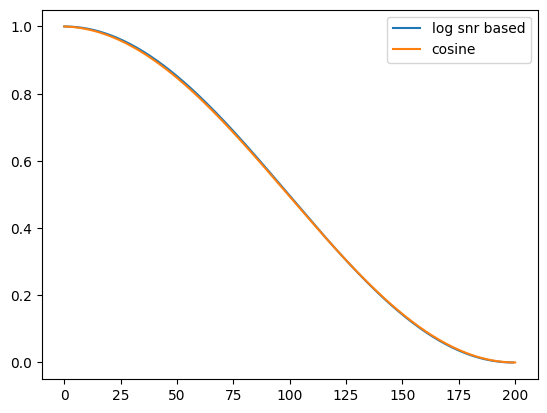

In [3]:
T = 200
# Cosine-inspired schedule based on Classifier-Free Guidance (log SNR based)
def log_snr_cosine_schedule(t):
    # t in [0, 1]
    min_log_snr, max_log_snr = torch.tensor(-20.0), torch.tensor(20.0)
    b = torch.atan(torch.exp(-max_log_snr / 2))
    a = torch.atan(torch.exp(-min_log_snr / 2)) - b
    log_snr = -2 * torch.log(torch.tan(a * t + b))
    return log_snr

t = torch.linspace(0, 1, T)
log_snr = log_snr_cosine_schedule(t)
alphas_bar = torch.sigmoid(log_snr)
sig_betas = 1 - alphas_bar[1:] / alphas_bar[:-1]
sig_betas = torch.cat([sig_betas[:1], sig_betas.clamp(0.0001, 0.9999)])

t = torch.arange(0, T + 1, dtype=torch.float32)
f_t = torch.cos(((t / T) + s) / (1 + s) * torch.pi / 2) ** 2
bar_alphas = f_t / f_t[0]

plt.plot(alphas_bar, label="log snr based")
plt.plot(bar_alphas, label="cosine")
plt.legend();

almost same as cosine

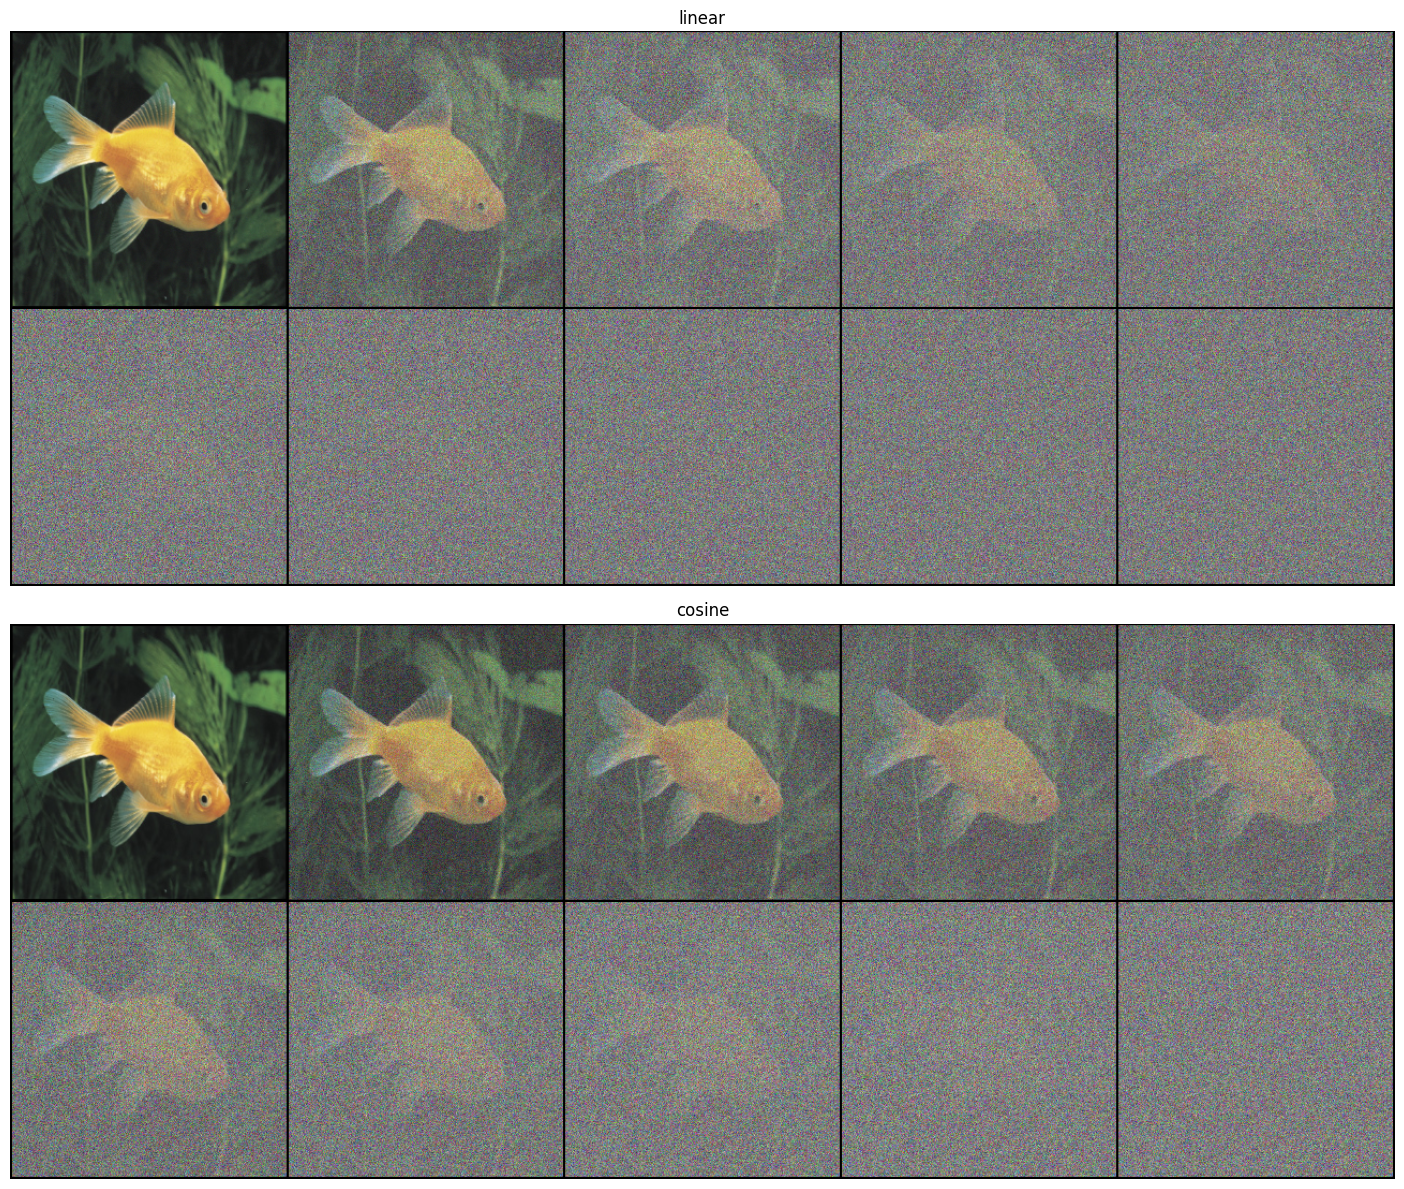

In [ ]:
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid

image_path = "./goldfish.JPEG"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 -1),
])
img = Image.open(image_path).convert("RGB")
img = transform(img)

img = img.unsqueeze(0)

def forward(x_0, bar_alphas, t):
    noise = torch.randn_like(x_0)
    sqrt_bar_alpha_t = torch.sqrt(bar_alphas[t])[:, None, None, None] # (B,1,1,1)
    sqrt_1_minus_bar_alpha_t = torch.sqrt(1.0 - bar_alphas[t])[:, None, None, None] # (B,1,1,1)
    return sqrt_bar_alpha_t * x_0 + sqrt_1_minus_bar_alpha_t * noise

T = 1000
beta_start = 1e-4
beta_end = 0.02

# linear
sig_betas = torch.linspace(beta_start, beta_end, T)
alphas = 1.0 - sig_betas
bar_alphas = torch.cumprod(alphas, dim=0)
t = torch.linspace(0, T-1, 10, dtype=torch.long)

plt.figure(figsize=(20, 12))
plt.subplot(2, 1, 1)
x_ts = forward(img, bar_alphas, t)
disp_img = make_grid(x_ts, nrow=5, scale_each=True, normalize=True)
disp_img = disp_img.permute(1, 2, 0)
plt.imshow(disp_img)
plt.title("linear")
plt.axis("off"); plt.tight_layout()

plt.subplot(2, 1, 2)
s = 0.008
t = torch.arange(0, T + 1, dtype=torch.float32)
f_t = torch.cos(((t / T) + s) / (1 + s) * torch.pi / 2) ** 2
bar_alphas = f_t / f_t[0]
t = torch.linspace(0, T-1, 10, dtype=torch.long)
x_ts = forward(img, bar_alphas, t)
disp_img = make_grid(x_ts, nrow=5, scale_each=True, normalize=True)
disp_img = disp_img.permute(1, 2, 0)
plt.imshow(disp_img)
plt.title("cosine");
plt.axis("off"); plt.tight_layout()


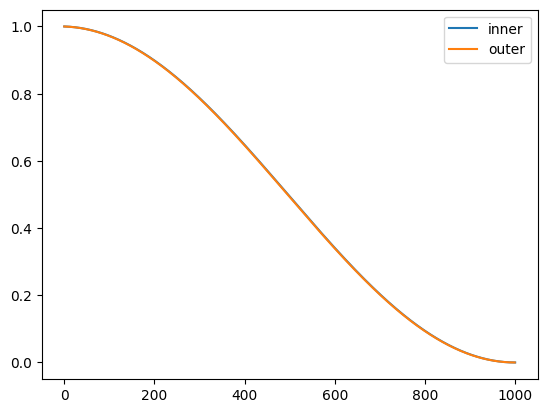

In [ ]:
T = 1000

s = 0.008
t = torch.arange(0, T + 1, dtype=torch.float32)
f_t = torch.cos(((t / T) + s) / (1 + s) * torch.pi / 2) ** 2
bar_alphas = f_t / f_t[0]
plt.plot(bar_alphas, label="inner")
betas = 1 - (bar_alphas[1:] / bar_alphas[:-1])
alphas = 1.0 - betas
bar_alphas = torch.cumprod(alphas, dim=0)
plt.plot(bar_alphas, label="outer")
plt.legend();

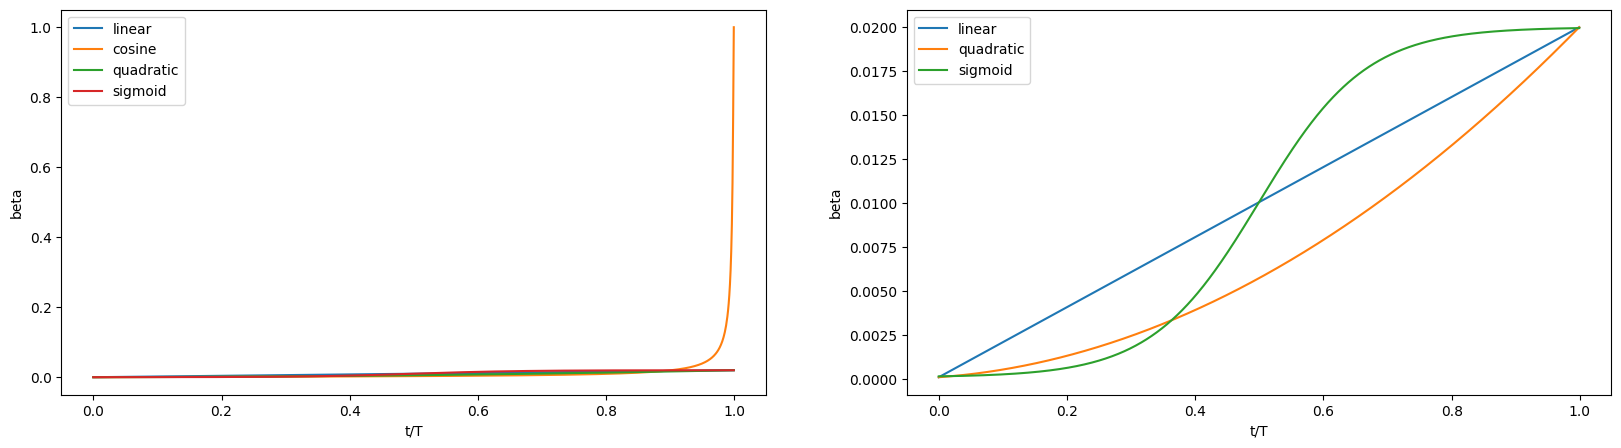

In [12]:
T = 1000

t_T = torch.arange(T) / T

# linear
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
beta_start = 1e-4
beta_end = 0.02
lin_betas = torch.linspace(beta_start, beta_end, T)
plt.plot(t_T, lin_betas, label="linear")
plt.xlabel("t/T")
plt.ylabel("beta")

# cosine
s = 0.008
t = torch.arange(0, T + 1, dtype=torch.float32)
f_t = torch.cos(((t / T) + s) / (1 + s) * torch.pi / 2) ** 2
bar_alphas = f_t / f_t[0]
cosine_betas = 1 - (bar_alphas[1:] / bar_alphas[:-1])
plt.plot(t_T, cosine_betas, label="cosine")

# quadratic
quad_betas = torch.linspace(beta_start**0.5, beta_end**0.5, T) ** 2
plt.plot(t_T, quad_betas, label="quadratic")

sig_betas = torch.linspace(-6, 6, T)
sig_betas = torch.sigmoid(sig_betas) * (beta_end - beta_start) + beta_start
plt.plot(t_T, sig_betas, label="sigmoid")

plt.legend();

plt.subplot(1, 2, 2)
plt.plot(t_T, lin_betas, label="linear")
plt.xlabel("t/T")
plt.ylabel("beta")
plt.plot(t_T, quad_betas, label="quadratic")
plt.plot(t_T, sig_betas, label="sigmoid")
plt.legend();